In [1]:
# Importing required libraries
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import integrate
import seaborn as sns

import bisect

# Define the number of bins for the histogram
num_bins = 100

# Define a color-palette to use.
# For example colorblind from seaborn
color_palette = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC",
            "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9"]

In [14]:
# Define the path to the root directory of the data
root_path = "./data/sampling/"

# Define the suffixes for the sample size files
sample_size_suffix_rq1 = "t2"
sample_size_suffix_rq2 = "sampleSize_300"
sample_size_suffix_discussion = "sampleSize_2100"

# Define the sampling strategies to use
sampling_strategies = [
    ('random', ';', color_palette[0], 'Uniform Random'),
    ('divDistBased', ';', color_palette[1], 'Distance-based'),
    ('solverBased', ';', color_palette[2], 'Solver-based'),
    ('SRSSampling', ',', color_palette[3], 'Statistical Recursive Search'),
    ]

# Number of sample sets per system and sampling strategy
number_of_sample_sets = 100

# configurable system names
cs_information = [
    ("7z", "Performance", "7z (Performance, t2)"),
    ("BerkeleyDBC", "Performance", "Berkeley DB (Performance, t2)"),
    ("Dune", "Performance", "Dune (Performance, t2)"),
    ("Hipacc", "Performance", "Hipacc (Performance, t2)"),
    ("JavaGC", "Performance", "Java GC (Performance, t2)"),
    ("LLVM", "Performance", "LLVM (Performance, t2)"),
    ("Polly", "Performance", "Polly (Performance, t2)"),
]

In [15]:
def estimate_epsilon(data, max):
    """
    Estimate the (posterior) probability of finding a value greater than max in the data.
    """
    return sum(i > max for i in data) / data.size

def estimate_epsilon_from_sorted(data, max):
    """
    Estimate the (posterior) probability of finding a value greater than max in the **sorted** data.
    """
    n = bisect.bisect_right(data, max)
    return (data.size - n) / data.size

def calculate_prior_beta(epsilon, sample_count):
    """
    Estimate the confidence in the estimate of epsilon given the number of samples.
    """
    return (1 - epsilon) ** (sample_count + 1)

def calculate_beta(epsilon, sample_count):
    """
    Estimate the confidence in the estimate of (posterior) epsilon given the number of samples.
    """
    if (epsilon == 0):
        return 0
    else:
        return (1 - epsilon) ** (sample_count + 1)

def ecdf(epsilon_values):
    """
    Compute the empirical cumulative distribution function of the epsilon values.
    Returns the sorted epsilon values and the corresponding cumulative probabilities.
    """
    epsilon_values_sorted = np.sort(epsilon_values)
    n = epsilon_values.size
    return epsilon_values_sorted, np.arange(1, n + 1) / n

def __get_y_value(x_values, y_values, step):
    """
    Get the y value for a given value (step) from an empirical cumulative distribution function.
    """
    n = bisect.bisect_left(x_values, step)
    return y_values[n - 1] if n > 0 else 0

def get_y_values(x_values, y_values, steps):
    """
    Get all y values for a given set of values (steps) from an empirical cumulative distribution function.
    """
    return [__get_y_value(x_values, y_values, step) for step in steps]

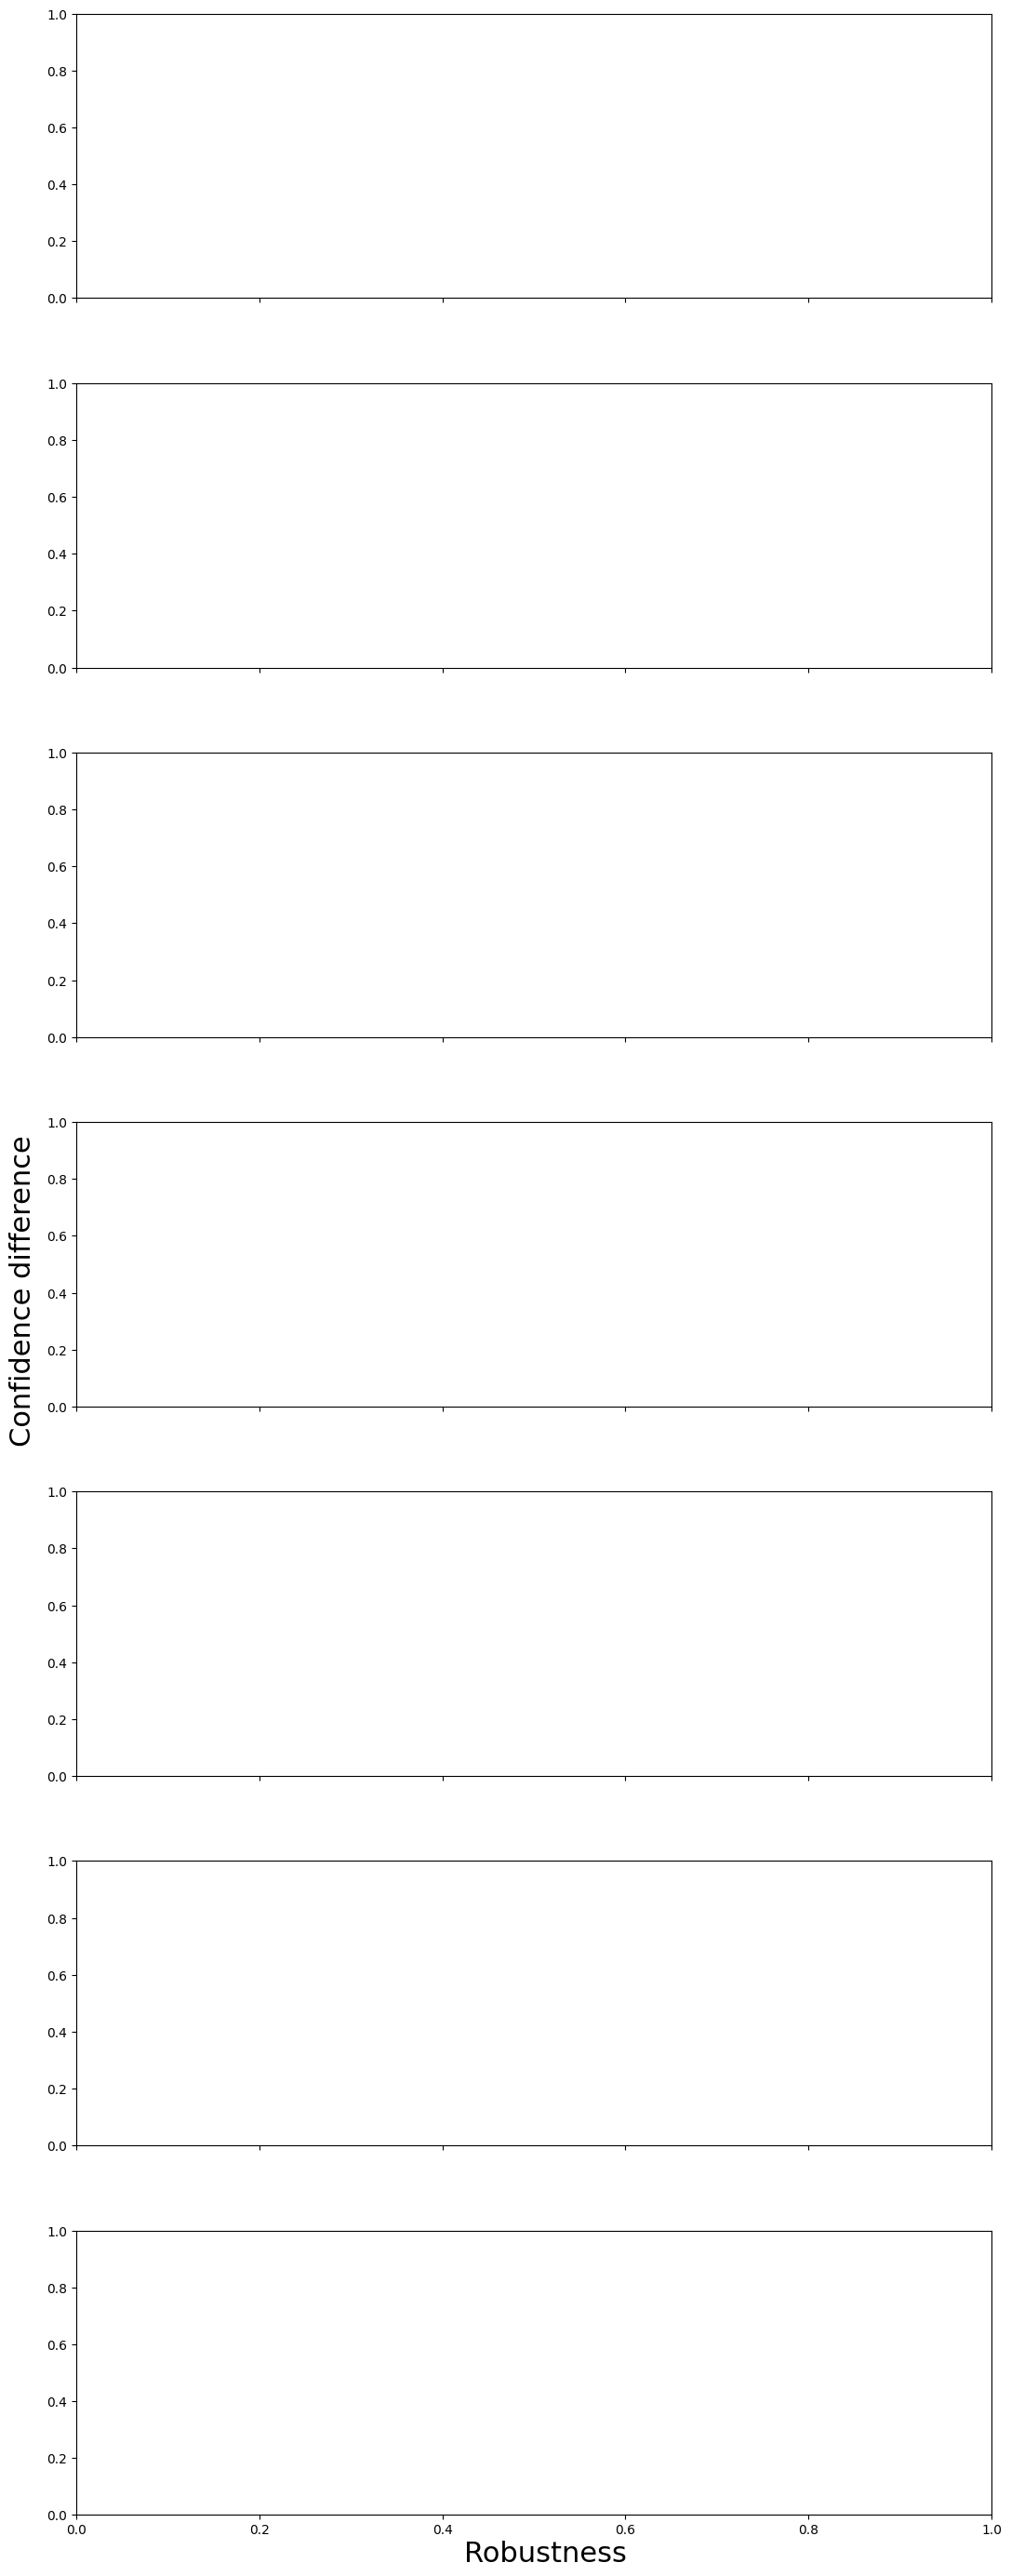

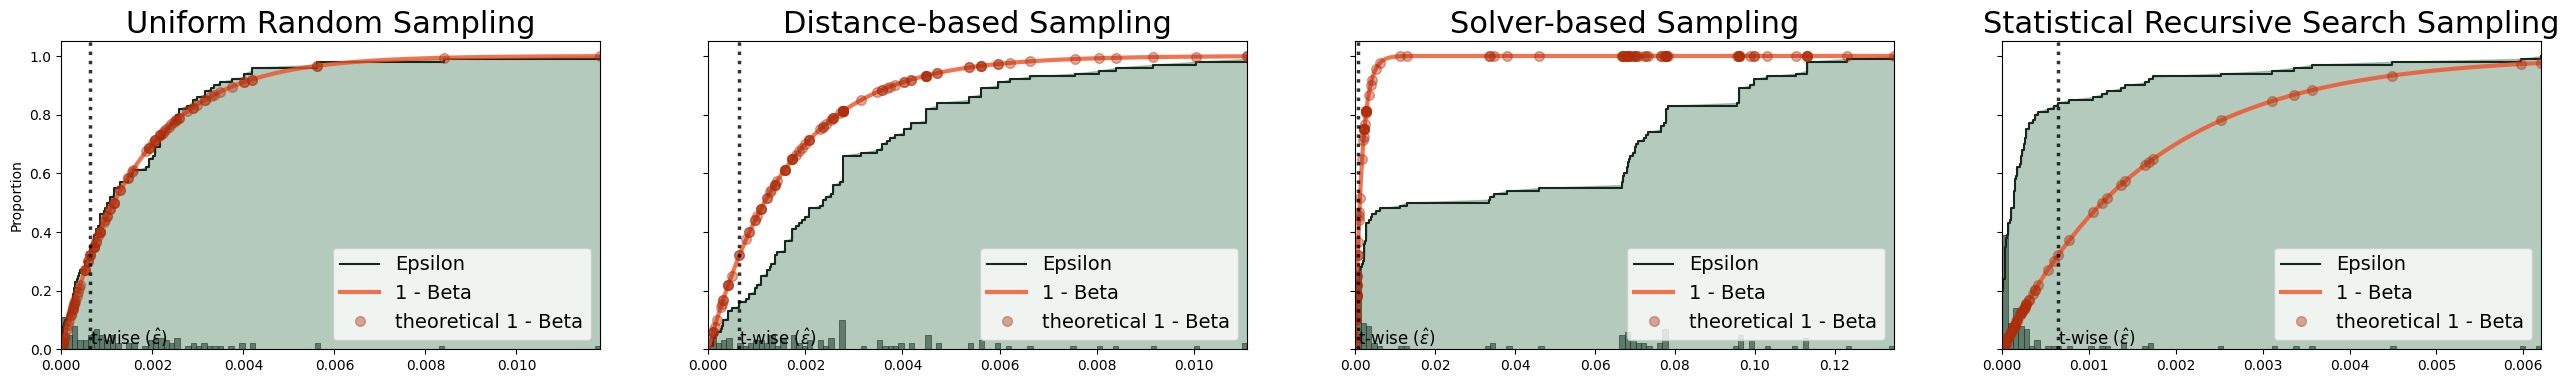

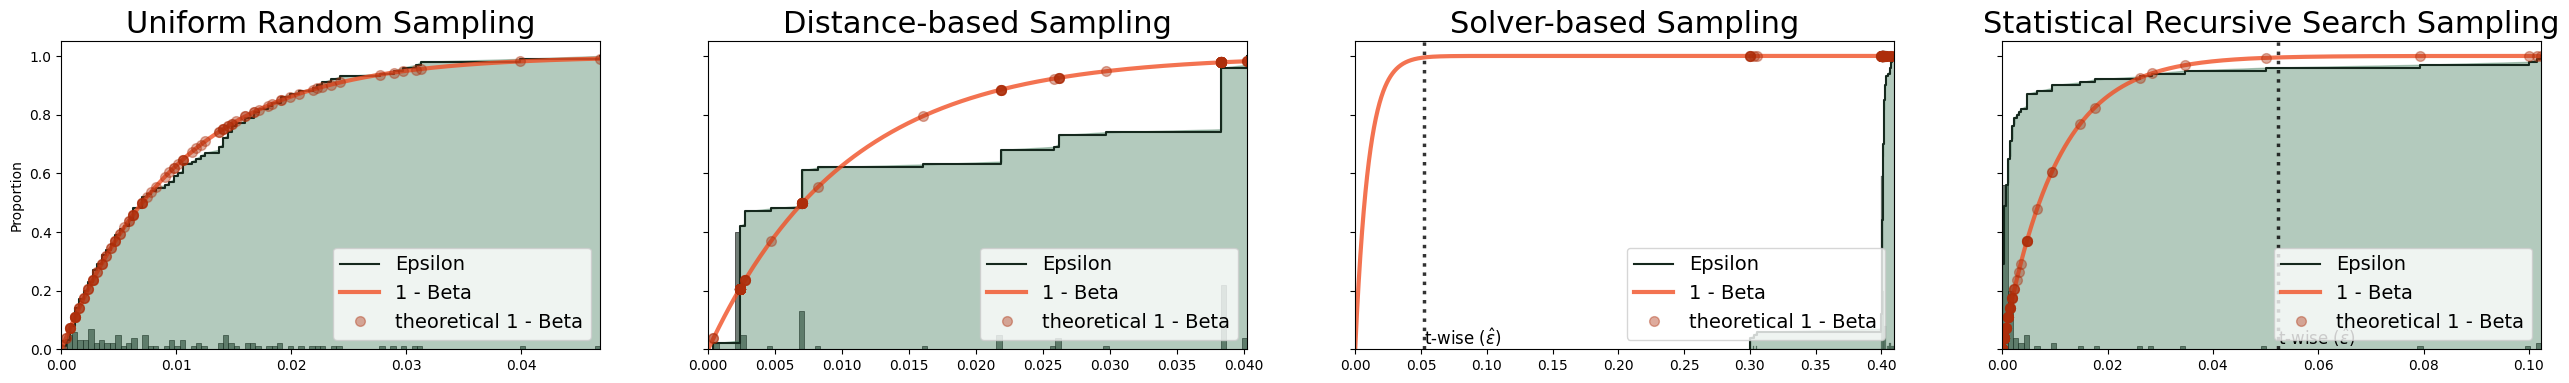

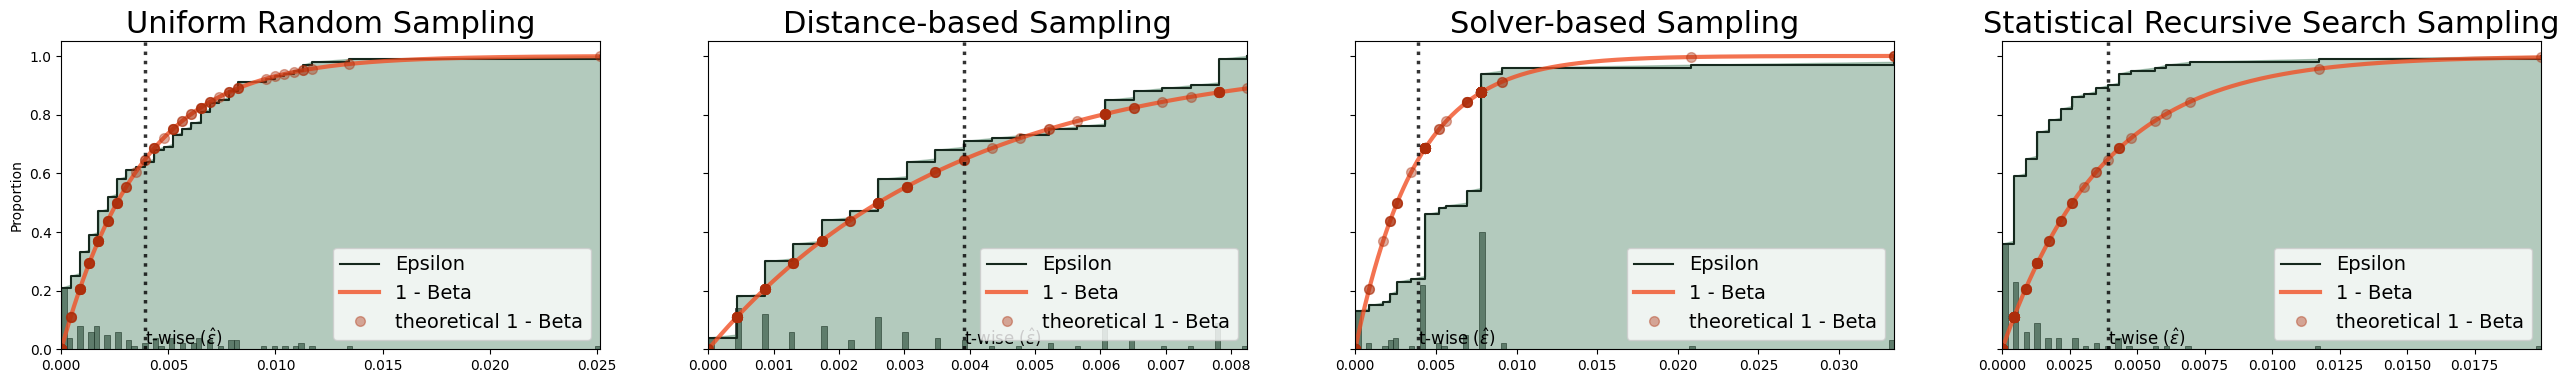

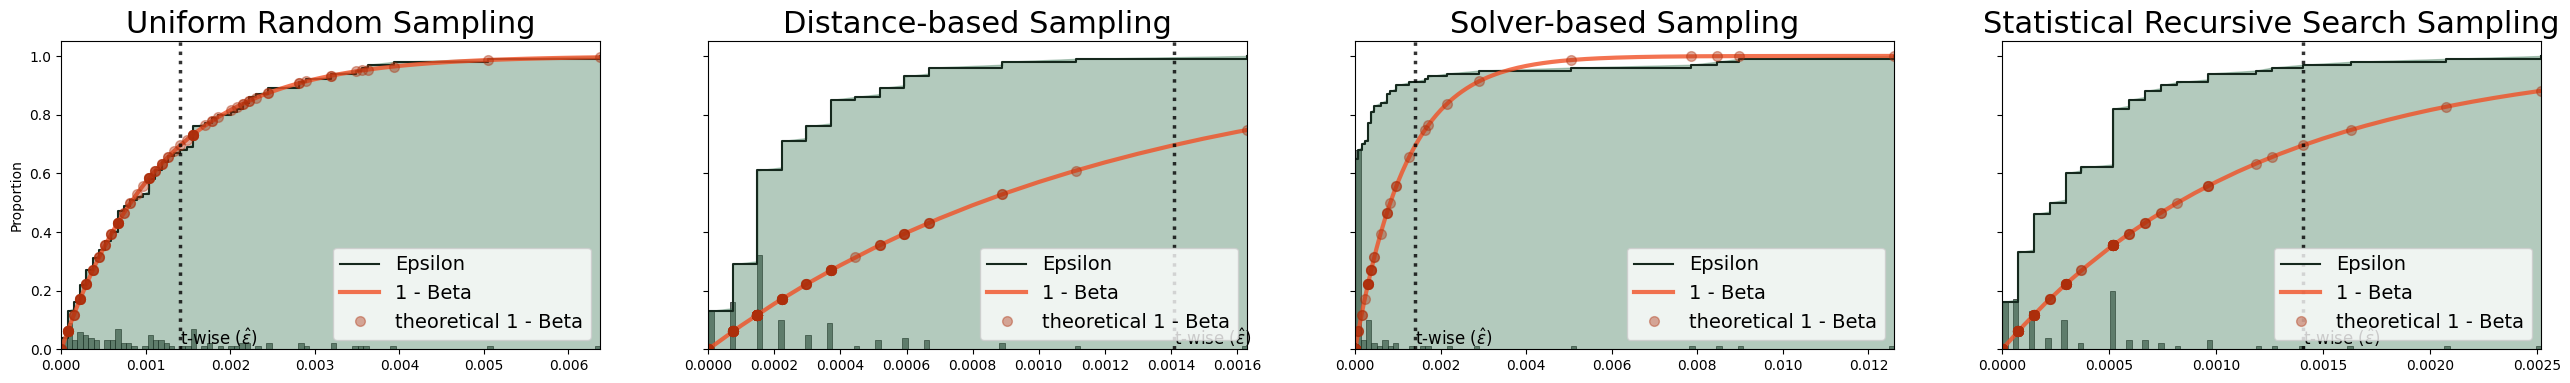

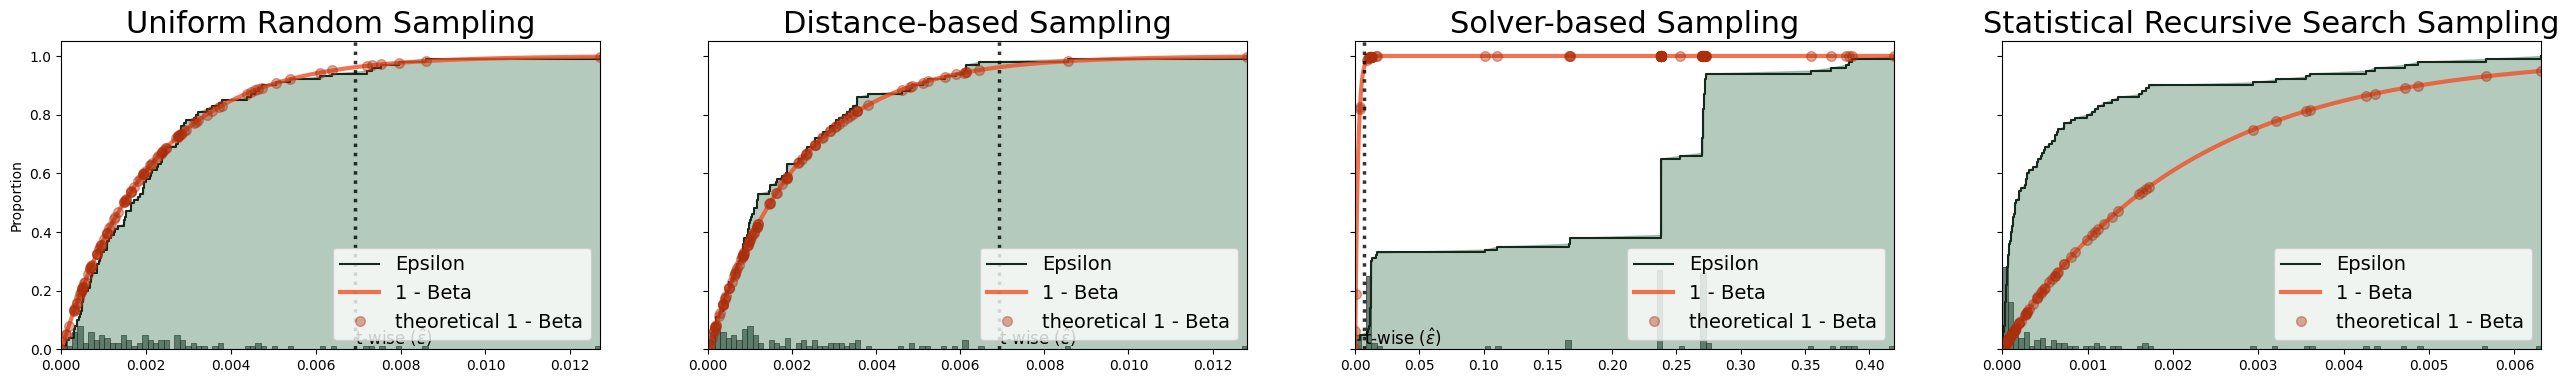

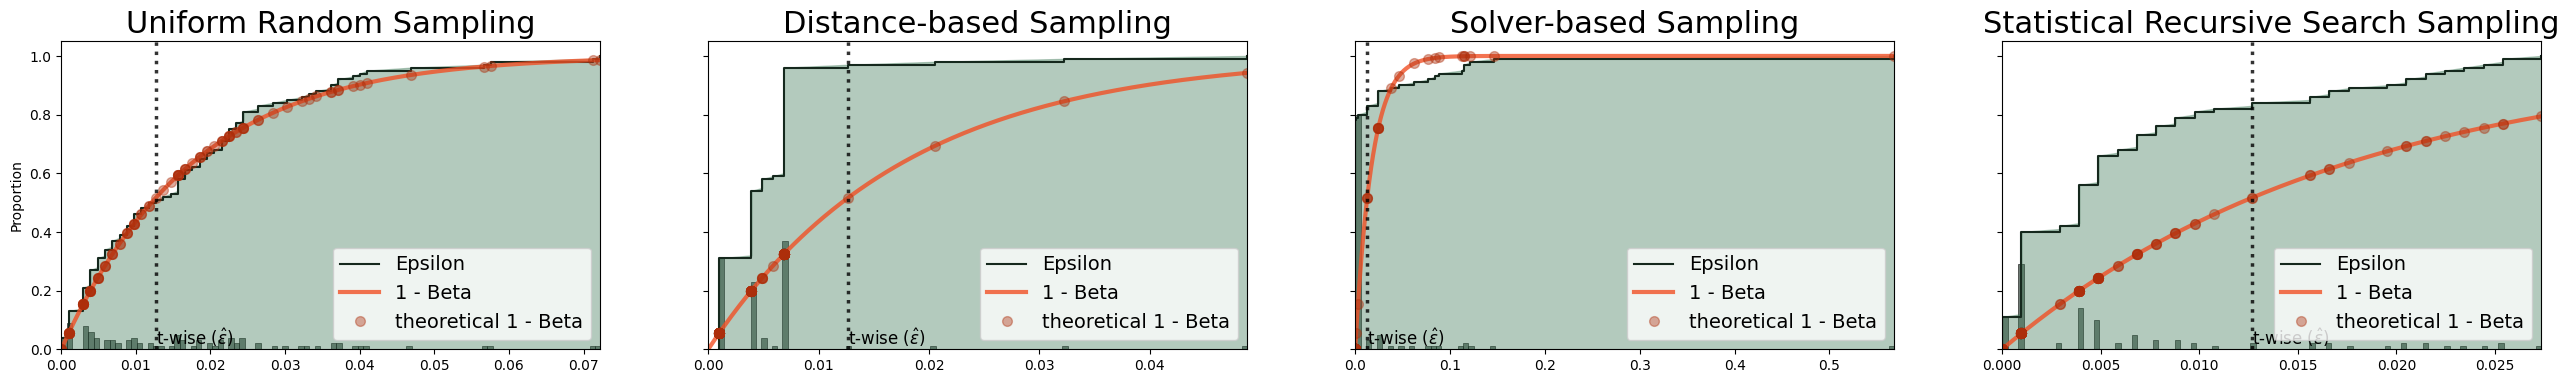

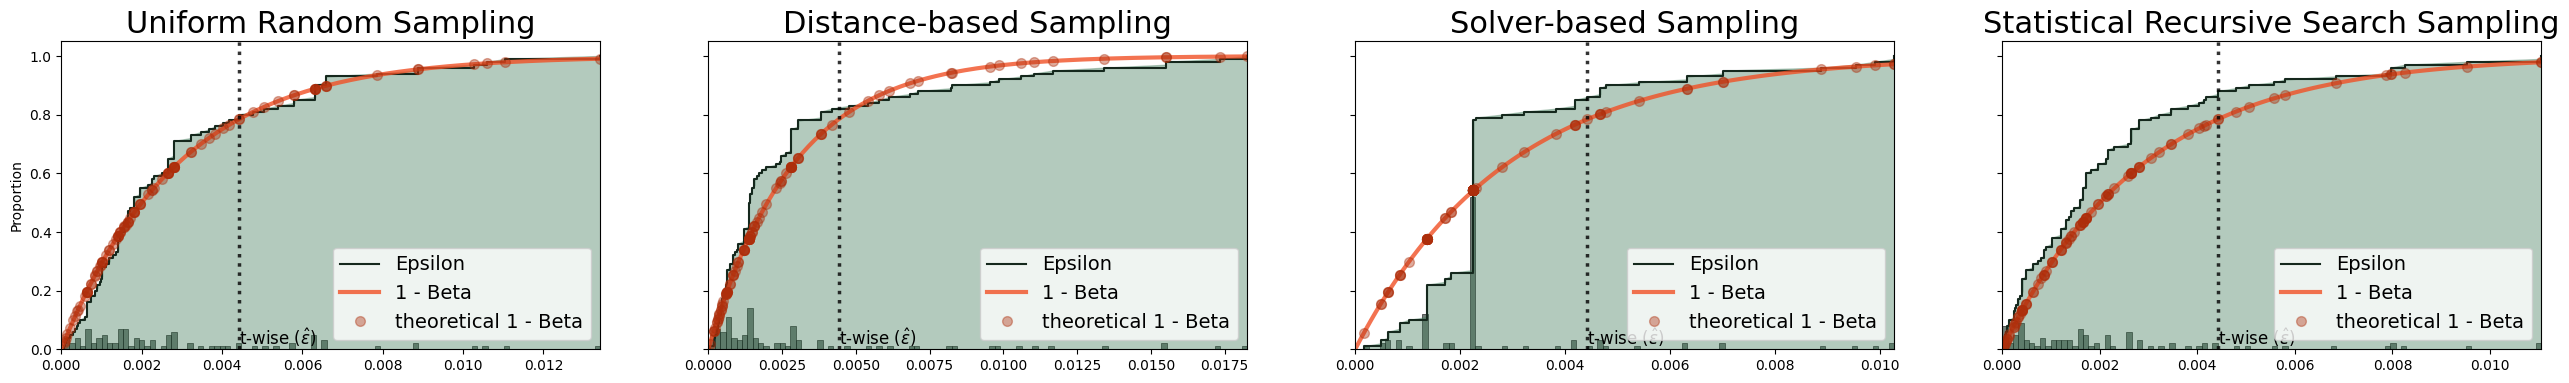

In [16]:
# Produce the plots for RQ 1

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}

# Data for the confidence discrepancy $\eta$ plot
confidence_difference_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Confidence Difference': []
}

# Data for the confidence plot
confidence_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Posterior Confidence': [],
    'Prior Confidence': []
}

# Define the steps for the curves in the confidence and confidence discrepancy plots
area_steps = [s / 10000 for s in range(0, 10000, 1)]

# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data

# Final figure for the paper including all case studies in a single figure (only the line plots for the differences between posterior and prior 1-beta values)
fig_paper, axes_paper = plt.subplots(len(cs_information), 1, figsize=(12, 4 * len(cs_information)), sharex=True)

for row_paper, (cs, nfp, diagram_title) in zip(range(len(cs_information)), cs_information):
    fig, axes = plt.subplots(1, 1 * len(sampling_strategies), figsize=(8 * len(sampling_strategies), 4), sharey=True)
    cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
    cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

    for (strategy, separator, color, strategy_title), row_i in zip(sampling_strategies, range(0, len(sampling_strategies))):

        epsilon_values_strategy = []
        inv_beta_values_strategy = []

        for i in range(1, number_of_sample_sets + 1):
            cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_rq1 + '.csv', sep=separator)
            cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
            cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

            epsilon_values_strategy.append(estimate_epsilon(cs_measurements, cs_sample_points.max()))
            inv_beta_values_strategy.append(1 - calculate_prior_beta(epsilon_values_strategy[-1], len(cs_sample_points)))

        number_of_samples = len(cs_sample_points)

        pot_epsilon_values = [i/10000 for i in range(0, 10000)]
        pot_inv_beta_values = [1 - calculate_prior_beta(epsilon, number_of_samples) for epsilon in pot_epsilon_values]

        data_df = pd.DataFrame({'epsilon': epsilon_values_strategy, '1-beta': inv_beta_values_strategy})
        sorted_data_df = data_df.sort_values('epsilon')

        epsilon_values_strategy = sorted_data_df['epsilon'].to_numpy()
        inv_beta_values_strategy = sorted_data_df['1-beta'].to_numpy()

        ax = axes[row_i]
        ax.axis(xmin=0.0, xmax=epsilon_values_strategy.max())
        y_bottom = 0.0
        y_top = 1.05
        ax.axis(ymin=y_bottom, ymax=y_top)

        sns.ecdfplot(epsilon_values_strategy, ax=ax, color='#15281d')

        ax.plot(pot_epsilon_values, pot_inv_beta_values, '#f15025', alpha=0.8, lw=3)
        ax.plot(epsilon_values_strategy, inv_beta_values_strategy, 'o', color='#ad2e0b', markersize=7, alpha=0.4, lw=2)
        ax.legend(['Epsilon', '1 - Beta', 'theoretical 1 - Beta'], fontsize=14, loc='lower right')
        ax.set_title(strategy_title + ' Sampling', fontsize=22)

        sns.histplot(x=epsilon_values_strategy, ax=ax, alpha=0.6, stat="probability", kde=False, bins=num_bins, color='#15281d')
    
        line1 = ax.lines[0]
        x1 = line1.get_xydata()[:,0]
        y1 = line1.get_xydata()[:,1]
        ax.fill_between(x1, y1, color='#417b5a', alpha=0.4)
        
        cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + 'twise' + '_' + sample_size_suffix_rq1 + '.csv', sep=';')
        cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
        cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()
        epsilon_t_wise = estimate_epsilon(cs_measurements, cs_sample_points.max())
        if (epsilon_t_wise < epsilon_values_strategy.max()):
            ax.axvline(epsilon_t_wise, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
            ax.text(epsilon_t_wise, y_bottom, 't-wise ($\hat{\epsilon}$)', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

        # Compute the plot to show the difference between posterior and prior 1-beta values
        posterior_epsilon_values[strategy] = ax.lines[0].get_xdata()[np.isfinite(ax.lines[0].get_xdata())]

        sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(posterior_epsilon_values[strategy])
        posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
        prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, number_of_samples) for area_step in area_steps])

        diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals

        # Add plot to the figure for the paper
        # axes_paper[row_paper].plot(posterior_epsilon_values[strategy], diff_inv_beta_values[strategy], '-', markersize=7, alpha=0.8, lw=2, color=color, label=strategy_title)
        # axes_paper[row_paper].plot(area_steps, diff_inv_beta_vals, '-', markersize=7, alpha=0.8, lw=2, color=color, label=strategy_title) #  label='_Hidden')

        confidence_difference_data['Case Study'].extend([cs] * len(area_steps))
        confidence_difference_data['Sampling Strategy'].extend([strategy] * len(area_steps))
        confidence_difference_data['Robustness'].extend(area_steps)
        confidence_difference_data['Confidence Difference'].extend(diff_inv_beta_vals)

        confidence_data['Case Study'].extend([cs] * len(area_steps))
        confidence_data['Sampling Strategy'].extend([strategy] * len(area_steps))
        confidence_data['Robustness'].extend(area_steps)
        confidence_data['Posterior Confidence'].extend(posterior_inv_beta_vals)
        confidence_data['Prior Confidence'].extend(prior_inv_beta_vals)

# Plot the different plots for the paper in a raw, matplotlib version
#   axes_paper[row_paper].axhline(0, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
#   axes_paper[row_paper].legend(fontsize=14, loc='lower right')
#   axes_paper[row_paper].axis(xmin=0.0, xmax=0.15)
#   axes_paper[row_paper].set_title(cs, fontsize=20, loc='left')

#   # if (epsilon_t_wise < 0.15):
#   #     axes_paper[row_paper].axvline(epsilon_t_wise, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
#   #     axes_paper[row_paper].text(epsilon_t_wise, y_bottom, 't-wise ($\hat{\epsilon}$)', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

#   for ax in axes:
#       ax.set_yticklabels([])
#       ax.set_ylabel('')

#   fig.suptitle(diagram_title, fontsize=32, y=0.98)
#   fig.supxlabel('Robustness', fontsize=22)
#   fig.supylabel('Confidence', fontsize=22)
#   fig.subplots_adjust(top = 0.70, bottom=0.18, left=0.04, right=0.99, hspace=0.3, wspace=0.08)
#   fig.savefig('results/' + cs  + '_robustness_distribution.pdf', format='pdf')
fig_paper.supxlabel('Robustness', fontsize=22)
fig_paper.supylabel('Confidence difference', fontsize=22)
fig_paper.subplots_adjust(top = 0.99, bottom=0.03, left=0.08, hspace=0.3, wspace=0.04)
#fig_paper.savefig('results/allCaseStudies_confidence_differences.pdf', format='pdf')
plt.show()

# Store the data for the confidence and confidence discrepancy plots to plot them in tikz, pgfplots
pd.DataFrame(confidence_difference_data).to_csv('data/sampling/confidence_difference_data.csv', index=False)
pd.DataFrame(confidence_data).to_csv('data/sampling/confidence_data.csv', index=False)

In [5]:
# Produce the data for the plots for RQ 2

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}
area_aggregates = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Sample Set Size': [],
    'Area': []
}

area_steps = [s / 10000 for s in range(0, 10000, 1)]

# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data
for (cs, nfp, _) in cs_information:
    cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
    cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

    for (strategy, separator, color, _), row_i in zip(sampling_strategies, range(0, len(sampling_strategies))):
        epsilon_values_strategy = []
        inv_beta_values_strategy = []

        epsilon_beta_values_area = {
            'Repetition': [],
            'Sample Set Size': [],
            'Epsilon Value': [],
        }
        inv_beta_values_area = []

        for i in range(1, number_of_sample_sets + 1):
            cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_rq2 + '.csv', sep=separator)
            cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
            cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

            # Collect the data for the different sample set sizes (we made sure to collect the samples inside the sets in the order provided by the sampling strategy)
            for bound in range(len(cs_sample_points), 0, -10):
                epsilon_beta_values_area['Repetition'].append(i)
                epsilon_beta_values_area['Sample Set Size'].append(bound)
                tmp_epsilon = estimate_epsilon(cs_measurements, cs_sample_points[:bound].max())
                epsilon_beta_values_area['Epsilon Value'].append(tmp_epsilon)

            epsilon_values_strategy.append(estimate_epsilon(cs_measurements, cs_sample_points.max()))
            inv_beta_values_strategy.append(1 - calculate_prior_beta(epsilon_values_strategy[-1], len(cs_sample_points)))

        epsilon_beta_values_area_df = pd.DataFrame(epsilon_beta_values_area)

        number_of_samples = len(cs_sample_points)

        pot_epsilon_values = [i/10000 for i in range(0, 10000)]
        pot_inv_beta_values = [1 - calculate_prior_beta(epsilon, number_of_samples) for epsilon in pot_epsilon_values]

        data_df = pd.DataFrame({'epsilon': epsilon_values_strategy, '1-beta': inv_beta_values_strategy})
        sorted_data_df = data_df.sort_values('epsilon')

        epsilon_values_strategy = sorted_data_df['epsilon'].to_numpy()
        inv_beta_values_strategy = sorted_data_df['1-beta'].to_numpy()

        for range_val in epsilon_beta_values_area_df['Sample Set Size'].drop_duplicates().sort_values(ascending=True):
            epsilon_vals = epsilon_beta_values_area_df[epsilon_beta_values_area_df['Sample Set Size'] == range_val]['Epsilon Value']
            sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(epsilon_vals)
            posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
            prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, range_val) for area_step in area_steps])

            diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals
            area_aggregates['Case Study'].append(cs)
            area_aggregates['Sampling Strategy'].append(strategy)
            area_aggregates['Sample Set Size'].append(range_val)
            area_aggregates['Area'].append(integrate.simpson(diff_inv_beta_vals, area_steps, even='first'))

area_aggregates_df = pd.DataFrame(area_aggregates)
area_aggregates_df.to_csv('data/sampling/area_aggregation.csv', index=False)


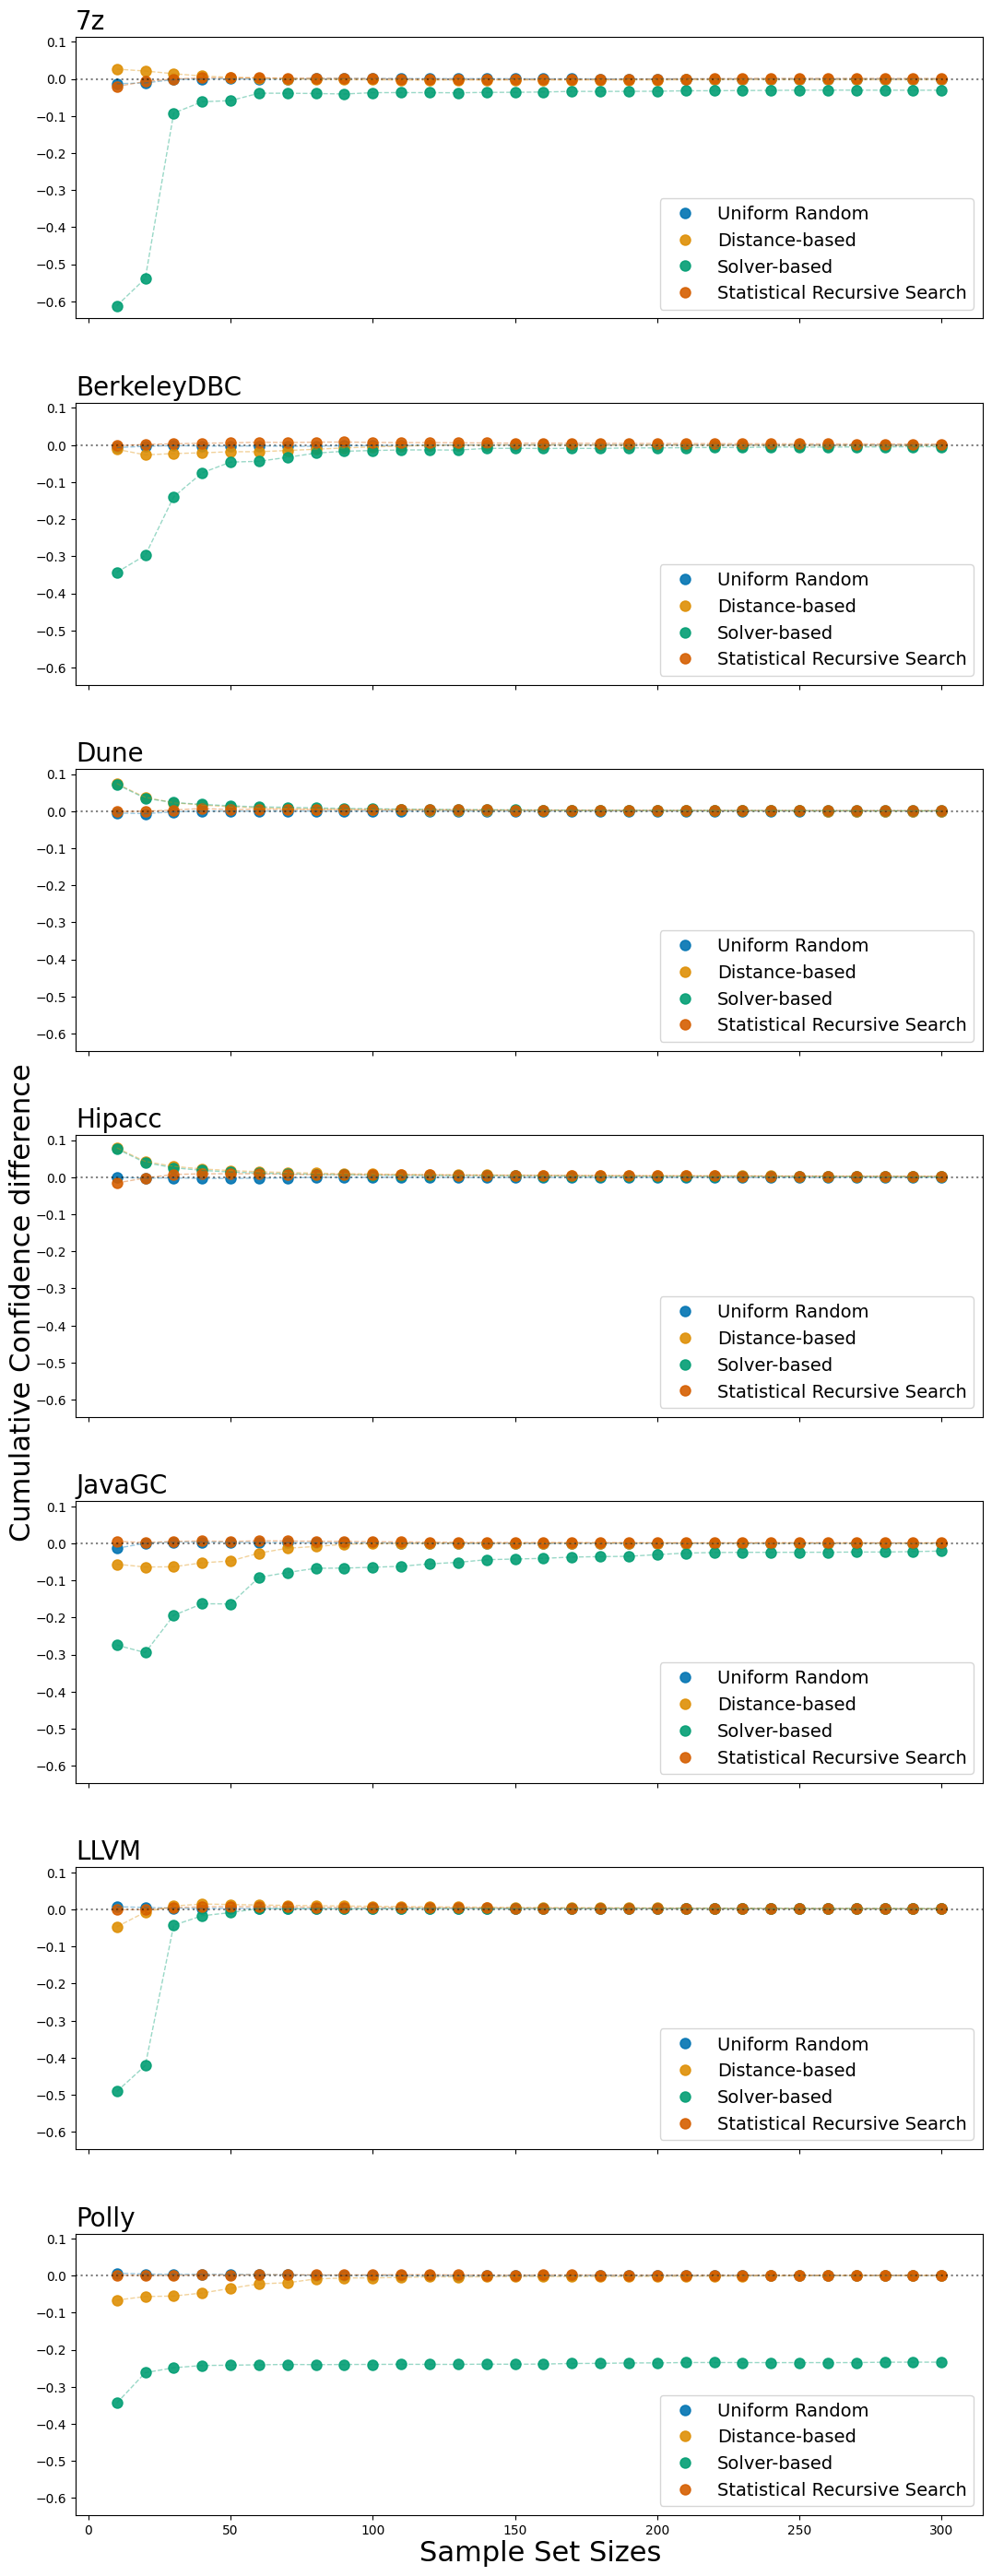

In [8]:
# Plot the integrated confidence discrepancy for the different sample set sizes
area_aggregates_df = pd.read_csv(root_path + 'area_aggregation.csv')

# width = 3
height = area_aggregates_df['Case Study'].nunique()

fig, axes = plt.subplots(height, 1, figsize=(12, 4 * height), sharey=True, sharex=True)

for ax in axes.flatten():
    ax.set_axis_off()

for case_study, ax in zip(area_aggregates_df['Case Study'].unique(), axes.flatten()):
    ax.set_axis_on()

    case_study_df = area_aggregates_df[area_aggregates_df['Case Study'] == case_study]

    for strategy, _, color, _ in sampling_strategies:
        strategy_df = case_study_df[case_study_df['Sampling Strategy'] == strategy]
        ax.plot(strategy_df['Sample Set Size'], strategy_df['Area'], 'o', markersize=8, alpha=0.9, color=color)
    ax.axhline(0, color='black', linestyle='dotted', linewidth=1.5, alpha=0.5)
    ax.legend([sampling_title for _, _, _, sampling_title in sampling_strategies], fontsize=14, loc='lower right')
    for strategy, _, color, _ in sampling_strategies:
        strategy_df = case_study_df[case_study_df['Sampling Strategy'] == strategy]
        ax.plot(strategy_df['Sample Set Size'], strategy_df['Area'], markersize=5, alpha=0.4, lw=1, linestyle='--', color=color)

    ax.set_title(case_study, fontsize=20, loc='left')

fig.supxlabel('Sample Set Sizes', fontsize=22)
fig.supylabel('Cumulative Confidence difference', fontsize=22)
fig.subplots_adjust(top = 0.99, bottom=0.03, left=0.08, hspace=0.3, wspace=0.01)

plt.show()

In [20]:
def compute_pot_area():
    pot_area = {
        'Sample Set Size': [],
        'Max Area': [],
        'Min Area': []
    }
    for i in range(1, 2301):
        pot_epsilon_values = [i/10000 for i in range(0, 10000)]
        pot_inv_beta_values = [1 - calculate_prior_beta(epsilon, i) for epsilon in pot_epsilon_values]

        pot_area['Sample Set Size'].append(i)
        pot_area['Max Area'].append(1 - integrate.simpson(pot_inv_beta_values, pot_epsilon_values, even='first'))
        pot_area['Min Area'].append(0 - integrate.simpson(pot_inv_beta_values, pot_epsilon_values, even='first'))
    return pd.DataFrame(pot_area)

pot_area_df = compute_pot_area()
pot_area_df.to_csv('data/sampling/potential_area.csv', index=False)

In [19]:
# Produce the data for the plots for Polly in the discussion

sample_size_suffix_discussion = "sampleSize_2100"

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}
area_aggregates = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Sample Set Size': [],
    'Area': []
}

area_steps = [s / 10000 for s in range(0, 10000, 1)]

# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data
(cs, nfp, _) = cs_information[-1]
cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

for (strategy, separator, color, _), row_i in zip(sampling_strategies[-2:], range(0, len(sampling_strategies[-2:]))):
    epsilon_beta_values_area = {
        'Repetition': [],
        'Sample Set Size': [],
        'Epsilon Value': [],
    }

    for i in range(1, number_of_sample_sets + 1):
        cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_discussion + '.csv', sep=separator)
        cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
        cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

        for bound in range(len(cs_sample_points), 0, -10):
            epsilon_beta_values_area['Repetition'].append(i)
            epsilon_beta_values_area['Sample Set Size'].append(bound)
            tmp_epsilon = estimate_epsilon(cs_measurements, cs_sample_points[:bound].max())
            epsilon_beta_values_area['Epsilon Value'].append(tmp_epsilon)

    epsilon_beta_values_area_df = pd.DataFrame(epsilon_beta_values_area)

    for range_val in epsilon_beta_values_area_df['Sample Set Size'].drop_duplicates().sort_values(ascending=True):
        epsilon_vals = epsilon_beta_values_area_df[epsilon_beta_values_area_df['Sample Set Size'] == range_val]['Epsilon Value']
        sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(epsilon_vals)
        posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
        prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, range_val) for area_step in area_steps])

        diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals
        area_aggregates['Case Study'].append(cs)
        area_aggregates['Sampling Strategy'].append(strategy)
        area_aggregates['Sample Set Size'].append(range_val)
        area_aggregates['Area'].append(integrate.simpson(diff_inv_beta_vals, area_steps, even='first'))

area_aggregates_df = pd.DataFrame(area_aggregates)
area_aggregates_df.to_csv('data/sampling/area_aggregation_polly_2100.csv', index=False)

KeyboardInterrupt: 

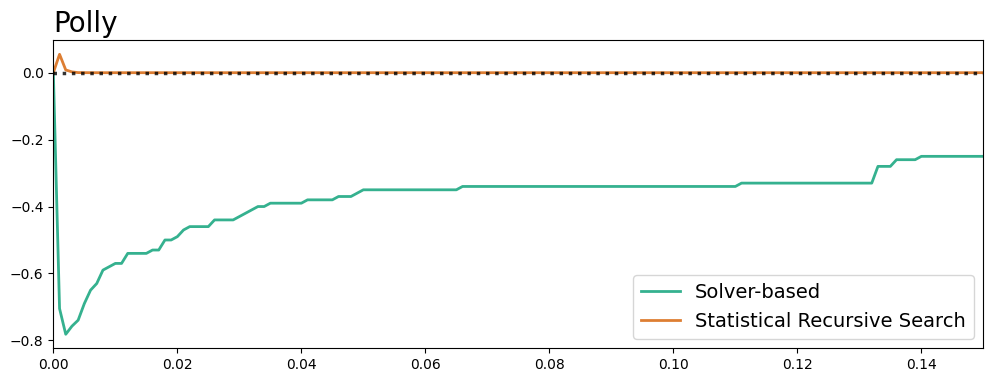

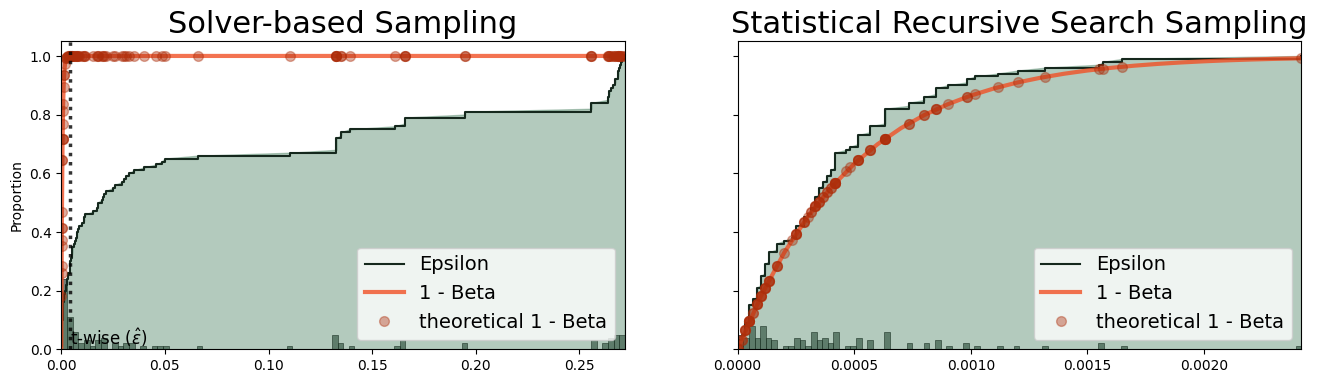

In [14]:
# Produce the plots for Discussion

# You can choose between the number of samples for which you want to look into the data

# lower bound for the number of samples
# discussion_bound = 15

# upper bound for the number of samples
discussion_bound = 2000

cs, nfp, diagram_title = cs_information[-1]  

discussion_sampling_strategies = sampling_strategies[-2:]

posterior_epsilon_values = {}
posterior_inv_beta_values = {}
diff_inv_beta_values = {}

confidence_difference_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Confidence Difference': []
}

confidence_data = {
    'Case Study': [],
    'Sampling Strategy': [],
    'Robustness': [],
    'Posterior Confidence': [],
    'Prior Confidence': []
}

area_steps = [s / 1000 for s in range(0, 1000, 1)]
# read the measurements of the configurable systems
# and read sample sets of configurable systems
# and aggregate the performance values for each sample set with the corresponding sample set data

# Final figure for the paper including all case studies in a single figure (only the line plots for the differences between posterior and prior 1-beta values)
fig_paper, axes_paper = plt.subplots(1, 1, figsize=(12, 4))

fig, axes = plt.subplots(1, 1 * len(discussion_sampling_strategies), figsize=(8 * len(discussion_sampling_strategies), 4), sharey=True)
cs_measurements_df = pd.read_csv(root_path + cs + '/measurements.csv') 
cs_measurements = cs_measurements_df[nfp].to_numpy().flatten()

for (strategy, separator, color, strategy_title), row_i in zip(discussion_sampling_strategies, range(0, len(discussion_sampling_strategies))):

    epsilon_values_strategy = []
    inv_beta_values_strategy = []

    for i in range(1, number_of_sample_sets + 1):
        cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + strategy + '_' + sample_size_suffix_discussion + '.csv', sep=separator)
        cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
        cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()

        epsilon_values_strategy.append(estimate_epsilon(cs_measurements, cs_sample_points[:discussion_bound].max()))
        inv_beta_values_strategy.append(1 - calculate_prior_beta(epsilon_values_strategy[-1], len(cs_sample_points[:discussion_bound])))

    number_of_samples = len(cs_sample_points[:discussion_bound])

    pot_epsilon_values = [i/10000 for i in range(0, 8000)]
    pot_inv_beta_values = [1 - calculate_prior_beta(epsilon, number_of_samples) for epsilon in pot_epsilon_values]

    data_df = pd.DataFrame({'epsilon': epsilon_values_strategy, '1-beta': inv_beta_values_strategy})
    sorted_data_df = data_df.sort_values('epsilon')

    epsilon_values_strategy = sorted_data_df['epsilon'].to_numpy()
    inv_beta_values_strategy = sorted_data_df['1-beta'].to_numpy()

    ax = axes[row_i]
    ax.axis(xmin=0.0, xmax=epsilon_values_strategy.max())
    y_bottom = 0.0
    y_top = 1.05
    ax.axis(ymin=y_bottom, ymax=y_top)

    sns.ecdfplot(epsilon_values_strategy, ax=ax, color='#15281d')

    ax.plot(pot_epsilon_values, pot_inv_beta_values, '#f15025', alpha=0.8, lw=3)
    ax.plot(epsilon_values_strategy, inv_beta_values_strategy, 'o', color='#ad2e0b', markersize=7, alpha=0.4, lw=2)
    ax.legend(['Epsilon', '1 - Beta', 'theoretical 1 - Beta'], fontsize=14, loc='lower right')
    ax.set_title(strategy_title + ' Sampling', fontsize=22)

    sns.histplot(x=epsilon_values_strategy, ax=ax, alpha=0.6, stat="probability", kde=False, bins=num_bins, color='#15281d')

    line1 = ax.lines[0]
    x1 = line1.get_xydata()[:,0]
    y1 = line1.get_xydata()[:,1]
    ax.fill_between(x1, y1, color='#417b5a', alpha=0.4)
    
    cs_sample_points_df = pd.read_csv(root_path + cs + '/' + cs + '_' + str(i) + '/sampledConfigurations_' + 'twise' + '_' + sample_size_suffix_rq1 + '.csv', sep=';')
    cs_sample_points_df = pd.merge(cs_sample_points_df, cs_measurements_df, on=list(cs_sample_points_df.columns), how='inner')
    cs_sample_points = cs_sample_points_df[nfp].to_numpy().flatten()
    epsilon_t_wise = estimate_epsilon(cs_measurements, cs_sample_points.max())
    if (epsilon_t_wise < epsilon_values_strategy.max()):
        ax.axvline(epsilon_t_wise, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
        ax.text(epsilon_t_wise, y_bottom, 't-wise ($\hat{\epsilon}$)', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

    # Compute the plot to show the difference between posterior and prior 1-beta values
    posterior_epsilon_values[strategy] = ax.lines[0].get_xdata()[np.isfinite(ax.lines[0].get_xdata())]

    sorted_epsilon_vals, posterior_inv_beta_vals = ecdf(posterior_epsilon_values[strategy])
    posterior_inv_beta_vals = np.array(get_y_values(sorted_epsilon_vals, posterior_inv_beta_vals, area_steps))
    prior_inv_beta_vals = np.array([1 - calculate_prior_beta(area_step, number_of_samples) for area_step in area_steps])

    diff_inv_beta_vals = posterior_inv_beta_vals - prior_inv_beta_vals

    # Add plot to the figure for the paper
    axes_paper.plot(area_steps, diff_inv_beta_vals, '-', markersize=7, alpha=0.8, lw=2, color=color, label=strategy_title) #  label='_Hidden')

    confidence_difference_data['Case Study'].extend([cs] * len(area_steps))
    confidence_difference_data['Sampling Strategy'].extend([strategy] * len(area_steps))
    confidence_difference_data['Robustness'].extend(area_steps)
    confidence_difference_data['Confidence Difference'].extend(diff_inv_beta_vals)

    confidence_data['Case Study'].extend([cs] * len(area_steps))
    confidence_data['Sampling Strategy'].extend([strategy] * len(area_steps))
    confidence_data['Robustness'].extend(area_steps)
    confidence_data['Posterior Confidence'].extend(posterior_inv_beta_vals)
    confidence_data['Prior Confidence'].extend(prior_inv_beta_vals)

axes_paper.axhline(0, color='black', linestyle='dotted', linewidth=2.5, alpha=0.8)
axes_paper.legend(fontsize=14, loc='lower right')
axes_paper.axis(xmin=0.0, xmax=0.15)
axes_paper.set_title(cs, fontsize=20, loc='left')

pd.DataFrame(confidence_difference_data).to_csv('data/sampling/confidence_difference_data_discussion_2000.csv', index=False)
pd.DataFrame(confidence_data).to_csv('data/sampling/confidence_data_discussion_2000.csv', index=False)


In [15]:
# Produce example data with different N for epsilon - beta relation

epsilon_beta_values = {
    'Sample Set Size': [],
    'Epsilon Value': [],
    '1 - Beta': []
}

for i in [15, 100, 250, 500, 1000, 2000]:
    epsilon_values = [i/10000 for i in range(0, 1000)]
    inv_beta_values = [1 - calculate_prior_beta(epsilon, i) for epsilon in epsilon_values]

    epsilon_beta_values['Sample Set Size'].extend([i] * len(epsilon_values))
    epsilon_beta_values['Epsilon Value'].extend(epsilon_values)
    epsilon_beta_values['1 - Beta'].extend(inv_beta_values)

epsilon_beta_values_df = pd.DataFrame(epsilon_beta_values)
epsilon_beta_values_df.to_csv('data/sampling/prior_epsilon_beta_values.csv', index=False)